In [1]:
import cellcharter as cc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import json
from scipy.stats import mannwhitneyu, kruskal, ttest_ind
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

/Users/lukashat/miniforge3/envs/cellcharter_scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [ ]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_3/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_3/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)

In [3]:
adata.obs['disease2'] = adata.obs['disease2'].astype(str)
adata = adata[adata.obs['disease2'].isin(['MM_BD', 'MM_noBD'])]
adata.obs['disease2'] = adata.obs['disease2'].astype('category')

# B

In [4]:
df = pd.crosstab(
    index=[adata.obs['patient_ID'], adata.obs['disease2']],
    columns=adata.obs['Phenotype4'],
    normalize='index'
)
summary_stats = df.groupby(level='disease2').agg(['mean'])
summary_stats.columns = summary_stats.columns.get_level_values(0)
summary_stats = summary_stats.reindex(['MM_BD', 'MM_noBD'])
summary_stats

Phenotype4,Adipocytes,CD4 T,CD8 T,DCs,Endothelial,HLA-DR+ Macs/monos,HSPCs,MPO+,Macs/monos,Neutrophils,OB/RUNX2+,Osteoclasts,Osteocytes,PCs,Unknown
disease2,,,,,,,,,,,,,,,
MM_BD,0.015899,0.033926,0.046706,0.009728,0.025964,0.048811,0.018249,0.061157,0.038958,0.214440,0.006781,0.001410,0.005118,0.338471,0.134380
MM_noBD,0.013063,0.026229,0.052211,0.008529,0.035893,0.039537,0.021891,0.059398,0.026635,0.172278,0.005002,0.000781,0.006890,0.419055,0.112609


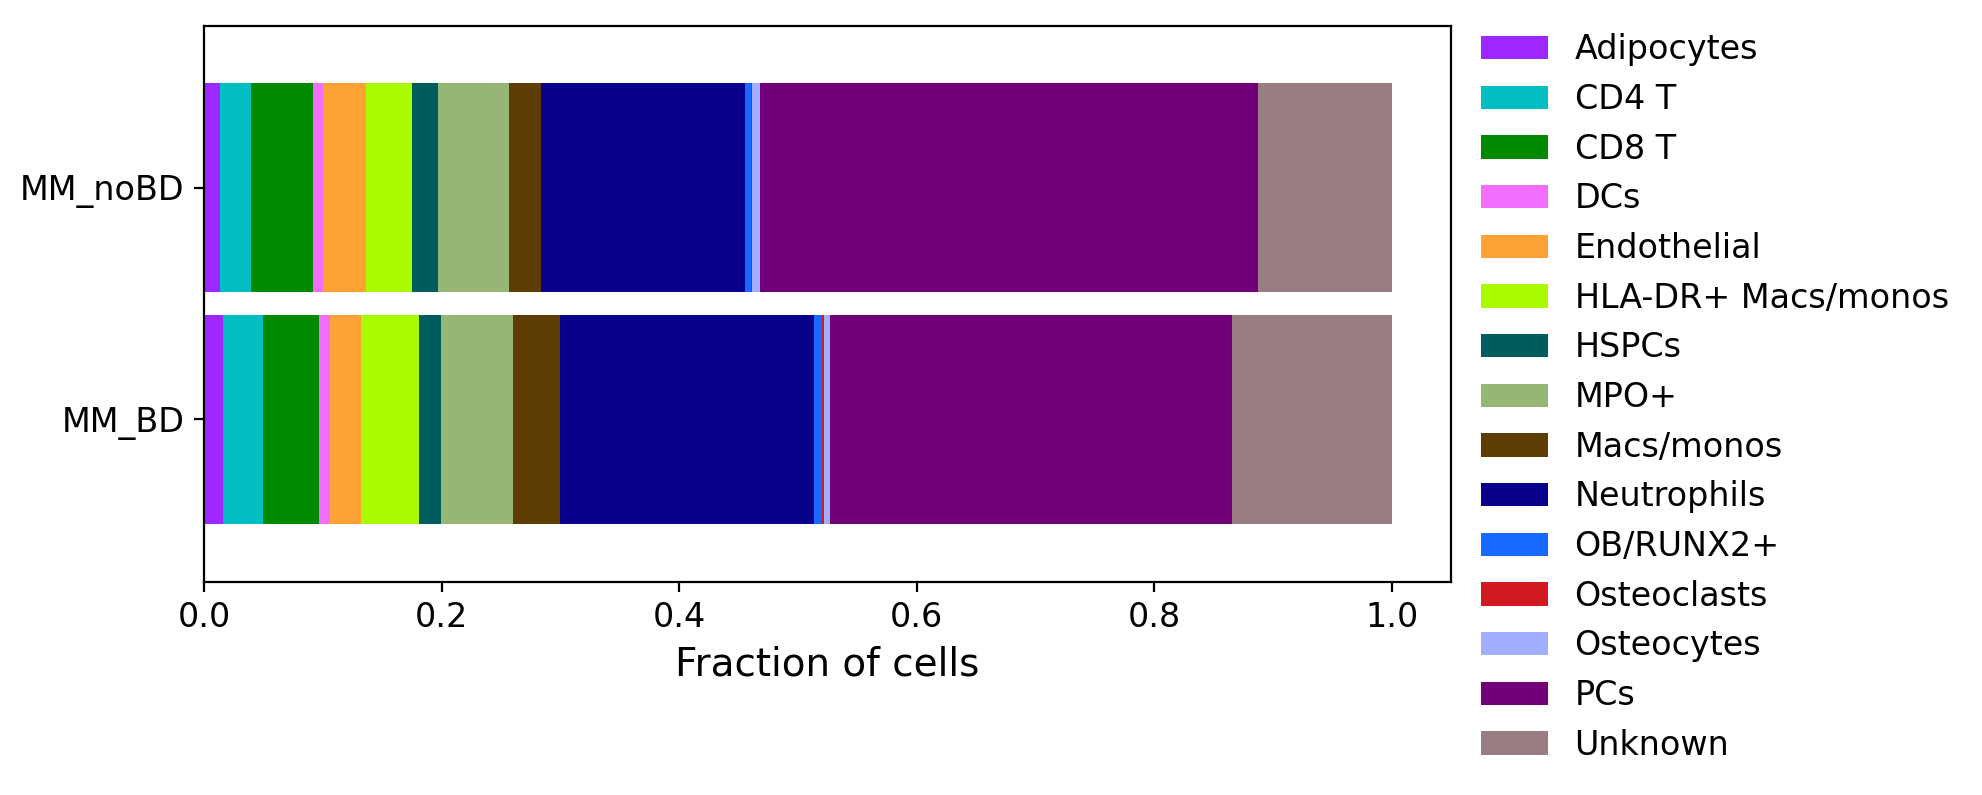

In [5]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 4))
summary_stats.plot(kind='barh', stacked=True, colormap=phenotype_colors, width = 0.9, ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.04), framealpha=0, facecolor='white', fontsize=12)
ax.set_ylabel('')
ax.set_xlabel('Fraction of cells', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig(os.path.join(save_path, f"phenotype_barplot.{extension}"))

# C

In [8]:
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")

In [9]:
grouped_df = pd.crosstab(
    [adata.obs['image_ID'], adata.obs['disease2']], 
    adata.obs['Phenotype4'],
    normalize='index'
)
grouped_df_long = grouped_df.reset_index().melt(
    id_vars=['image_ID', 'disease2'],
    var_name='Phenotype4',
    value_name='Percentage'
)
osteoclasts_df_freq = grouped_df_long[grouped_df_long['Phenotype4'] == 'Osteoclasts']
cell_counts = (
    adata.obs.groupby(['image_ID', 'Phenotype4'])
    .size()
    .reset_index(name='count')
)

In [10]:
image_disease_map = adata.obs[['image_ID', 'disease2']].drop_duplicates().set_index('image_ID')['disease2']
osteoclasts_df = cell_counts[cell_counts['Phenotype4'] == 'Osteoclasts']
osteoclasts_df['disease2'] = osteoclasts_df['image_ID'].map(image_disease_map)
osteoblasts_df = cell_counts[cell_counts['Phenotype4'] == 'Osteoblast lineage']
osteoblasts_df['disease2'] = osteoblasts_df['image_ID'].map(image_disease_map)

In [11]:
cell_counts['disease2'] = cell_counts['image_ID'].map(image_disease_map)
pivot_df = cell_counts.pivot_table(values='count', 
                                   index=['image_ID', 'disease2'], 
                                   columns='Phenotype4', 
                                   fill_value=0).reset_index()
pivot_df = pivot_df.rename(columns={'Osteoclasts': 'Osteoclast_count', 
                                    'OB/RUNX2+': 'OB/RUNX2+_count'})

In [12]:
# boxplot with ratio of osteoblasts to osteoclasts
## filter for images with OC and OBs
pivot_df = pivot_df[(pivot_df['Osteoclast_count'] > 0) & (pivot_df['OB/RUNX2+_count'] > 0)]
pivot_df['Osteoclast_OB/RUNX2+_ratio'] = pivot_df['Osteoclast_count'] / pivot_df['OB/RUNX2+_count']
pivot_df['RUNX2+_ratio_Osteoclast_ratio'] = pivot_df['OB/RUNX2+_count'] / pivot_df['Osteoclast_count']
pivot_df

Phenotype4,image_ID,disease2,Adipocytes,CD4 T,CD8 T,DCs,Endothelial,HLA-DR+ Macs/monos,HSPCs,MPO+,Macs/monos,Neutrophils,OB/RUNX2+_count,Osteoclast_count,Osteocytes,PCs,Unknown,Osteoclast_OB/RUNX2+_ratio,RUNX2+_ratio_Osteoclast_ratio
5,TS-373_IMC03_MGUS_002.csv,MGUS,54.0,458.0,170.0,98.0,133.0,598.0,235.0,1143.0,264.0,1697.0,61.0,7.0,261.0,710.0,1213.0,0.114754,8.714286
7,TS-373_IMC04_MGUS_002.csv,MGUS,73.0,403.0,215.0,102.0,57.0,745.0,132.0,250.0,295.0,1578.0,43.0,8.0,44.0,497.0,1052.0,0.186047,5.375000
8,TS-373_IMC05_MGUS_001.csv,SMM,47.0,215.0,158.0,44.0,157.0,357.0,56.0,209.0,198.0,1245.0,33.0,5.0,13.0,702.0,1202.0,0.151515,6.600000
10,TS-373_IMC07_UB_001.csv,MM_noBD,94.0,115.0,518.0,4.0,104.0,119.0,40.0,113.0,146.0,267.0,6.0,2.0,30.0,5702.0,423.0,0.333333,3.000000
11,TS-373_IMC07_UB_002.csv,MM_noBD,104.0,48.0,689.0,1.0,175.0,205.0,35.0,82.0,132.0,321.0,8.0,3.0,2.0,7712.0,725.0,0.375000,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,TS-373_IMC90.1_B_001.csv,MM_BD,22.0,376.0,280.0,137.0,37.0,336.0,88.0,281.0,70.0,2049.0,24.0,1.0,6.0,2742.0,930.0,0.041667,24.000000
143,TS-373_IMC90.1_B_002.csv,MM_BD,52.0,311.0,209.0,121.0,38.0,432.0,72.0,247.0,158.0,1691.0,36.0,5.0,33.0,1524.0,537.0,0.138889,7.200000
146,TS-373_IMC93_B_001.csv,MM_BD,149.0,163.0,372.0,25.0,251.0,222.0,257.0,322.0,362.0,1335.0,61.0,4.0,38.0,1071.0,950.0,0.065574,15.250000
147,TS-373_IMC93_B_002.csv,MM_BD,136.0,72.0,300.0,15.0,181.0,67.0,180.0,286.0,307.0,958.0,37.0,13.0,49.0,2403.0,962.0,0.351351,2.846154


In [13]:
pivot_df['disease2'].value_counts()

disease2
MM_BD      74
MM_noBD    12
MGUS        3
SMM         2
Name: count, dtype: int64

Mann–Whitney U test statistic: 465.0
P-value: 0.7983398438198002


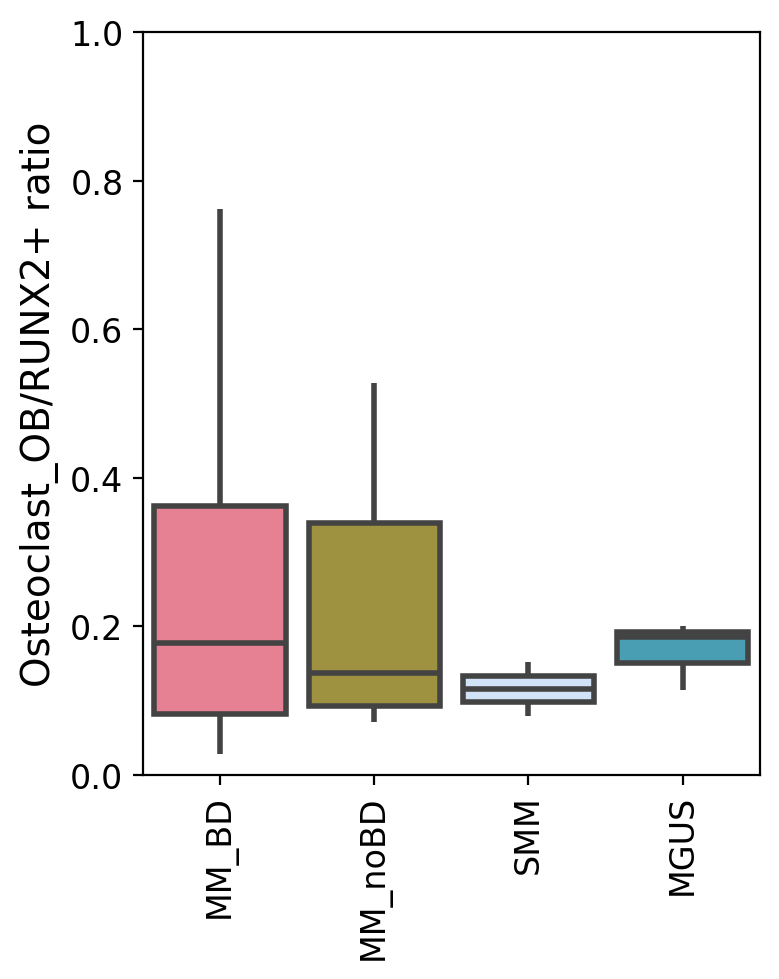

In [14]:
fig, ax = plt.subplots(figsize=(4,5))
sns.boxplot(
    data=pivot_df,
    x='disease2',
    y='Osteoclast_OB/RUNX2+_ratio',
    palette=disease_color_map,
    order=['MM_BD', 'MM_noBD', 'SMM', 'MGUS'],showcaps=False,
    linewidth=2,
    width=0.85,
    ax=ax,
    showfliers=False  # Add this line to hide outliers
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
ax.set_ylabel('Osteoclast_OB/RUNX2+ ratio', fontsize=14)
ax.set_xlabel('')
mm_bd = pivot_df[pivot_df['disease2'] == 'MM_BD']['Osteoclast_OB/RUNX2+_ratio']
mm_no_bd = pivot_df[pivot_df['disease2'] == 'MM_noBD']['Osteoclast_OB/RUNX2+_ratio']
stat, p_value = mannwhitneyu(mm_bd, mm_no_bd, alternative='two-sided')
print("Mann–Whitney U test statistic:", stat)
print("P-value:", p_value)
plt.tight_layout()
plt.savefig(os.path.join(save_path_supp, f'osteoclast_osteoblast_ratio.{extension}'))

In [15]:
targets = ['MM_BD', 'MM_noBD', 'SMM', 'MGUS']
filtered_df = pivot_df[pivot_df['disease2'].isin(targets)]
groups = [group['Osteoclast_OB/RUNX2+_ratio'].values for _, group in filtered_df.groupby('disease2')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")

Kruskal-Wallis H-stat: 0.604, p-val: 0.8956


In [16]:
osteoclasts_df

,image_ID,Phenotype4,count,disease2
11,TS-373_IMC01_UB_001.csv,Osteoclasts,0,MM_noBD
26,TS-373_IMC01_UB_002.csv,Osteoclasts,0,MM_noBD
41,TS-373_IMC02_MGUS_001.csv,Osteoclasts,0,MGUS
56,TS-373_IMC02_MGUS_002.csv,Osteoclasts,0,MGUS
71,TS-373_IMC03_MGUS_001.csv,Osteoclasts,0,MGUS
...,...,...,...,...
2216,TS-373_IMC93_B_002.csv,Osteoclasts,13,MM_BD
2231,TS-373_IMC95_B_001.csv,Osteoclasts,0,MM_BD
2246,TS-373_IMC95_B_002.csv,Osteoclasts,0,MM_BD
2261,TS-373_IMC96_B_001.csv,Osteoclasts,0,MM_BD


# D

In [23]:
adata_thresholds = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_thresholds_scanorama.h5ad")
adata_all = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
adata_thresholds.obs

,Object,area,Y_centroid,X_centroid,axis_major_length,axis_minor_length,eccentricity,distance_to_bone,Phenotype,image_ID,...,Phenotype3,cellcharter_CN,Ki67_counts,IDO_counts,GranzymeB_counts,GranzymeK_counts,CD68_counts,HLA-DR_counts,IRF4_counts,Phenotype4
Object 1 in TS-373_IMC77_B_001.csv,1,16,0.562500,801.750000,8.430760,2.420699,0.957893,26.019224,Unknown,TS-373_IMC77_B_001.csv,...,Plasma Cells/MM cells,stroma_adipocyte,0,0,0,0,0,0,0,Plasma Cells/MM cells
Object 2 in TS-373_IMC77_B_001.csv,2,12,0.833333,859.583333,5.176698,2.940449,0.823017,84.005952,Unknown,TS-373_IMC77_B_001.csv,...,Unknown,bone,1,0,1,0,0,0,0,Unknown
Object 3 in TS-373_IMC77_B_001.csv,3,13,0.846154,34.000000,5.203549,3.076923,0.806443,123.405835,Neutrophils,TS-373_IMC77_B_001.csv,...,Neutrophils,hypoxic_immune,0,0,0,0,0,0,0,Neutrophils
Object 4 in TS-373_IMC77_B_001.csv,4,9,1.000000,42.000000,3.265986,3.265986,0.000000,118.713942,Unknown,TS-373_IMC77_B_001.csv,...,Unknown,stroma_adipocyte,0,0,0,0,0,0,0,Unknown
Object 5 in TS-373_IMC77_B_001.csv,5,23,1.478261,57.565217,8.151264,3.901335,0.878024,110.476242,Unknown,TS-373_IMC77_B_001.csv,...,Unknown,pc_myeloid,1,0,0,0,0,0,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Object 6622 in TS-373_IMC83_B_001.csv,6622,11,998.000000,883.545455,4.077022,3.677860,0.431538,250.503493,Neutrophils,TS-373_IMC83_B_001.csv,...,Neutrophils,hypoxic_immune,1,1,1,1,1,0,0,Neutrophils
Object 6623 in TS-373_IMC83_B_001.csv,6623,27,997.407407,978.703704,7.171071,5.069573,0.707266,327.273586,CD4+Tcells,TS-373_IMC83_B_001.csv,...,CD4+Tcells,pc_myeloid,0,0,1,0,1,0,0,CD4+Tcells
Object 6624 in TS-373_IMC83_B_001.csv,6624,25,997.640000,996.320000,7.554137,4.235920,0.827991,342.067245,Neutrophils,TS-373_IMC83_B_001.csv,...,Neutrophils,bone_myeloid,1,0,1,0,1,0,0,Neutrophils
Object 6625 in TS-373_IMC83_B_001.csv,6625,13,997.692308,820.153846,5.547002,3.412473,0.788377,195.256242,activated Macrophages/Monocytes,TS-373_IMC83_B_001.csv,...,activated Macrophages/Monocytes,pc_myeloid,1,0,1,1,1,1,0,activated Macrophages/Monocytes


In [24]:
adata_all.obs['Ki67_counts'] = adata_all.obs.index.map(adata_thresholds.obs['Ki67_counts'])
adata_all.obs['proliferating_cells'] =  adata_all.obs['Phenotype4'].astype(str) + '_' + adata_all.obs['Ki67_counts'].astype(str)
adata_all.obs

,Object,area,Y_centroid,X_centroid,axis_major_length,axis_minor_length,eccentricity,distance_to_bone,image_ID,disease,patient_ID,ROI,disease2,distance_to_bone_corrected,cellcharter_CN,Phenotype4,HistoneH3,disease3,Ki67_counts,proliferating_cells
Object 1 in TS-373_IMC77_B_001.csv,1,16,0.562500,801.750000,8.430760,2.420699,0.957893,26.019224,TS-373_IMC77_B_001.csv,MM_BD,IMC77,001,MM_BD,26.019224,ADIPOCYTES_PC,PCs,4.374106,MM,0,PCs_0
Object 2 in TS-373_IMC77_B_001.csv,2,12,0.833333,859.583333,5.176698,2.940449,0.823017,84.005952,TS-373_IMC77_B_001.csv,MM_BD,IMC77,001,MM_BD,84.005952,BONE_ADIPOCYTES,Unknown,3.578988,MM,1,Unknown_1
Object 3 in TS-373_IMC77_B_001.csv,3,13,0.846154,34.000000,5.203549,3.076923,0.806443,123.405835,TS-373_IMC77_B_001.csv,MM_BD,IMC77,001,MM_BD,123.405835,HIF1A_IMMUNE,Neutrophils,2.832795,MM,0,Neutrophils_0
Object 4 in TS-373_IMC77_B_001.csv,4,9,1.000000,42.000000,3.265986,3.265986,0.000000,118.713942,TS-373_IMC77_B_001.csv,MM_BD,IMC77,001,MM_BD,118.713942,ADIPOCYTES_PC,Unknown,2.353134,MM,0,Unknown_0
Object 5 in TS-373_IMC77_B_001.csv,5,23,1.478261,57.565217,8.151264,3.901335,0.878024,110.476242,TS-373_IMC77_B_001.csv,MM_BD,IMC77,001,MM_BD,110.476242,PC_MYELOID,Unknown,3.813037,MM,1,Unknown_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Object 6622 in TS-373_IMC83_B_001.csv,6622,11,998.000000,883.545455,4.077022,3.677860,0.431538,250.503493,TS-373_IMC83_B_001.csv,MM_BD,IMC83,001,MM_BD,250.503493,HIF1A_IMMUNE,Neutrophils,4.890736,MM,1,Neutrophils_1
Object 6623 in TS-373_IMC83_B_001.csv,6623,27,997.407407,978.703704,7.171071,5.069573,0.707266,327.273586,TS-373_IMC83_B_001.csv,MM_BD,IMC83,001,MM_BD,327.273586,PC_MYELOID,CD4 T,4.770726,MM,0,CD4 T_0
Object 6624 in TS-373_IMC83_B_001.csv,6624,25,997.640000,996.320000,7.554137,4.235920,0.827991,342.067245,TS-373_IMC83_B_001.csv,MM_BD,IMC83,001,MM_BD,342.067245,BONE_MYELOID,Neutrophils,5.153814,MM,1,Neutrophils_1
Object 6625 in TS-373_IMC83_B_001.csv,6625,13,997.692308,820.153846,5.547002,3.412473,0.788377,195.256242,TS-373_IMC83_B_001.csv,MM_BD,IMC83,001,MM_BD,195.256242,PC_MYELOID,HLA-DR+ Macs/monos,4.905291,MM,1,HLA-DR+ Macs/monos_1


In [25]:
df = pd.crosstab(
    index=[adata_all.obs['image_ID'], adata_all.obs['disease2']],
    columns=adata_all.obs['proliferating_cells'],
    normalize='index'
)
df

,proliferating_cells,Adipocytes_0,Adipocytes_1,CD4 T_0,CD4 T_1,CD8 T_0,CD8 T_1,DCs_0,DCs_1,Endothelial_0,Endothelial_1,...,OB/RUNX2+_0,OB/RUNX2+_1,Osteoclasts_0,Osteoclasts_1,Osteocytes_0,Osteocytes_1,PCs_0,PCs_1,Unknown_0,Unknown_1
image_ID,disease2,,,,,,,,,,,,,,,,,,,,,
TS-373_IMC01_UB_001.csv,MM_noBD,0.004724,0.003070,0.010628,0.003307,0.017950,0.011337,0.006613,0.003779,0.016769,0.005905,...,0.002598,0.001653,0.000000,0.000000,0.020076,0.004960,0.115966,0.033302,0.015352,0.166509
TS-373_IMC01_UB_002.csv,MM_noBD,0.009964,0.002264,0.019475,0.006341,0.028986,0.010643,0.028759,0.007699,0.018795,0.006793,...,0.001359,0.000679,0.000000,0.000000,0.012455,0.001359,0.168705,0.044384,0.031024,0.164176
TS-373_IMC02_MGUS_001.csv,MGUS,0.002975,0.005168,0.011275,0.004541,0.026308,0.015503,0.006577,0.002975,0.005168,0.004228,...,0.002819,0.001566,0.000000,0.000000,0.000000,0.000000,0.099906,0.050110,0.026151,0.341372
TS-373_IMC02_MGUS_002.csv,MGUS,0.002903,0.008088,0.013273,0.003111,0.020116,0.011613,0.012028,0.004977,0.013065,0.005185,...,0.003111,0.001244,0.000000,0.000000,0.043965,0.020531,0.083783,0.042721,0.032974,0.286810
TS-373_IMC03_MGUS_001.csv,MGUS,0.006408,0.002603,0.020425,0.011614,0.017221,0.010212,0.002203,0.002002,0.006408,0.004205,...,0.003204,0.002203,0.000000,0.000000,0.058070,0.023228,0.084902,0.021225,0.038046,0.180617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TS-373_IMC93_B_002.csv,MM_BD,0.004861,0.017935,0.007543,0.004526,0.032350,0.017935,0.001173,0.001341,0.017935,0.012404,...,0.004190,0.002011,0.001844,0.000335,0.007710,0.000503,0.241703,0.161079,0.013242,0.148005
TS-373_IMC95_B_001.csv,MM_BD,0.018677,0.002025,0.002475,0.000900,0.004050,0.000225,0.000225,0.000225,0.006526,0.001575,...,0.001125,0.000000,0.000000,0.000000,0.003150,0.000000,0.027003,0.004050,0.112061,0.065032
TS-373_IMC95_B_002.csv,MM_BD,0.005121,0.000749,0.000125,0.000000,0.001624,0.000125,0.000125,0.000000,0.001124,0.000500,...,0.000250,0.000250,0.000000,0.000000,0.000000,0.000000,0.013365,0.002373,0.109043,0.100300


In [26]:
df = df[['OB/RUNX2+_0', 'OB/RUNX2+_1']]
df['OB/RUNX2+_proliferation_ratio'] = df['OB/RUNX2+_1'] / (df['OB/RUNX2+_0'] + df['OB/RUNX2+_1'])
df 

,proliferating_cells,OB/RUNX2+_0,OB/RUNX2+_1,OB/RUNX2+_proliferation_ratio
image_ID,disease2,,,
TS-373_IMC01_UB_001.csv,MM_noBD,0.002598,0.001653,0.388889
TS-373_IMC01_UB_002.csv,MM_noBD,0.001359,0.000679,0.333333
TS-373_IMC02_MGUS_001.csv,MGUS,0.002819,0.001566,0.357143
TS-373_IMC02_MGUS_002.csv,MGUS,0.003111,0.001244,0.285714
TS-373_IMC03_MGUS_001.csv,MGUS,0.003204,0.002203,0.407407
...,...,...,...,...
TS-373_IMC93_B_002.csv,MM_BD,0.004190,0.002011,0.324324
TS-373_IMC95_B_001.csv,MM_BD,0.001125,0.000000,0.000000
TS-373_IMC95_B_002.csv,MM_BD,0.000250,0.000250,0.500000


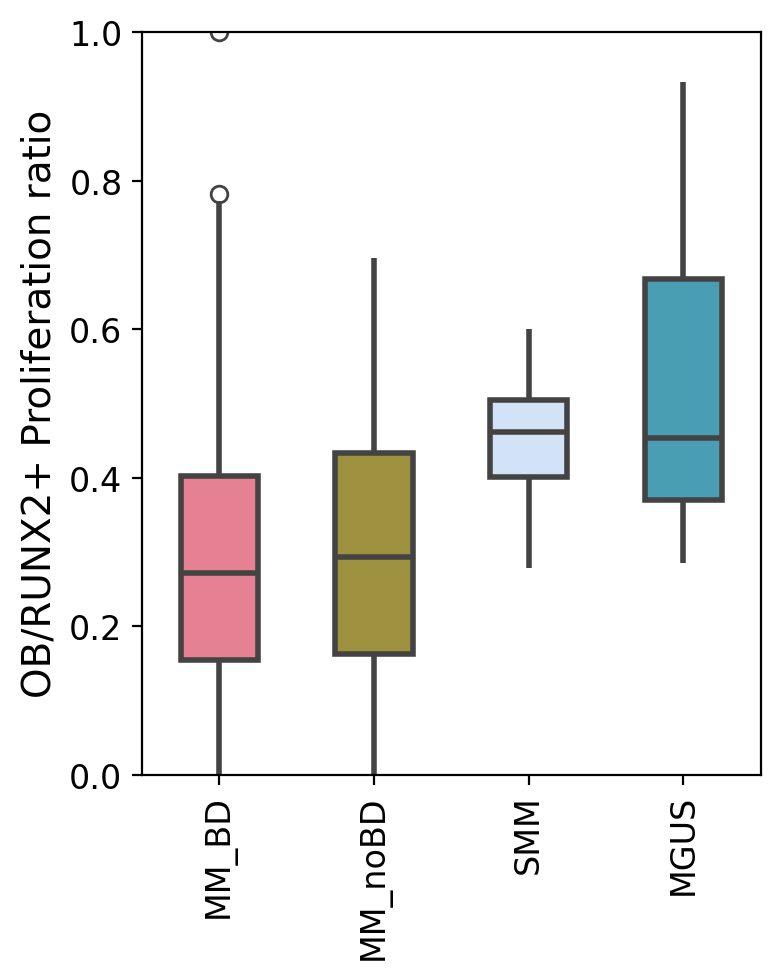

In [27]:
fig, ax = plt.subplots(figsize=(4, 5))
sns.boxplot(data=df.reset_index(), x='disease2', y='OB/RUNX2+_proliferation_ratio', order=['MM_BD', 'MM_noBD', 'SMM', 'MGUS'], palette=disease_color_map, ax=ax, showcaps=False, linewidth=2, width=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('OB/RUNX2+ Proliferation ratio', fontsize=14 )
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'ob_proliferation_index.{extension}'))

In [28]:
targets = ['MM_BD', 'MM_noBD', 'SMM', 'MGUS']
df_reset = df.reset_index()
filtered_df = df_reset[df_reset['disease2'].isin(targets)]
groups = [group['OB/RUNX2+_proliferation_ratio'].values for _, group in filtered_df.groupby('disease2')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")

Kruskal-Wallis H-stat: 16.786, p-val: 0.0008


In [29]:
dunn_results = sp.posthoc_dunn(
    filtered_df,
    val_col='OB/RUNX2+_proliferation_ratio',
    group_col='disease2',
    p_adjust='bonferroni'
)
print("\nDunn's posthoc results:")
dunn_results


Dunn's posthoc results:


,MGUS,MM_BD,MM_noBD,SMM
MGUS,1.000000,0.015435,0.107612,1.000000
MM_BD,0.015435,1.000000,1.000000,0.015359
MM_noBD,0.107612,1.000000,1.000000,0.130455
SMM,1.000000,0.015359,0.130455,1.000000


# F

In [ ]:
# see fiure_3_OC_neighborhood.ipynb

# G-J

In [48]:
celltype = 'PCs'
adata.obs['disease2'] = adata.obs['disease2'].astype(str)
adata = adata[adata.obs['disease2'].isin(['MM_BD', 'MM_noBD'])]
adata.obs['disease2'] = adata.obs['disease2'].astype('category')
disease_mapping = adata.obs[['disease2', 'image_ID']].drop_duplicates()
disease_mapping.set_index('image_ID', inplace=True)

In [49]:
df = adata[
    (adata.obs['Phenotype4'] == celltype)].to_df()
df['distance_to_bone_corrected'] = adata.obs.loc[df.index, 'distance_to_bone_corrected']
df['disease2'] = adata.obs.loc[df.index, 'disease2']
df['distance_bin'] = pd.cut(df['distance_to_bone_corrected'], 
                           bins=range(0, 1251, 250))

In [50]:
df

,CD38,Perilipin,Vimentin,B4GALT1,MPO,CathepsinK,ATP5A,RUNX2,HIF1A,CD11b,...,CollagenTypeI,CD3,CPT1A,CD98,HLA-DR,ST6GAL1,CD138,distance_to_bone_corrected,disease2,distance_bin
Object 1 in TS-373_IMC77_B_001.csv,0.285836,0.294962,0.381280,0.208380,0.470309,0.000000,0.347032,0.118177,0.245371,0.422768,...,0.698834,0.785446,0.734610,0.277531,0.523756,0.136619,0.104558,26.019224,MM_BD,"(0, 250]"
Object 15 in TS-373_IMC77_B_001.csv,0.584050,0.226002,0.743808,0.527641,0.396565,0.118083,0.357526,0.018114,0.512743,0.553887,...,0.044117,0.351875,0.695553,0.258422,0.396671,0.371555,0.546733,91.241438,MM_BD,"(0, 250]"
Object 32 in TS-373_IMC77_B_001.csv,0.391237,0.254091,0.419591,0.333855,0.669573,0.089656,0.375071,0.034897,0.222456,0.423251,...,1.058062,0.377810,0.568603,0.245792,0.209839,0.352995,0.122934,2.000000,MM_BD,"(0, 250]"
Object 60 in TS-373_IMC77_B_001.csv,0.563274,0.243710,0.785126,0.545517,0.465828,0.098735,0.654439,0.057979,0.563328,0.603363,...,0.037422,0.263463,0.769195,0.328007,0.321675,0.445502,0.397583,86.145226,MM_BD,"(0, 250]"
Object 75 in TS-373_IMC77_B_001.csv,0.608792,0.340158,0.683539,0.554623,0.654572,0.102201,0.610767,0.145675,0.482252,0.577713,...,0.304837,0.607238,0.694769,0.453150,0.501196,0.458932,0.391751,21.540659,MM_BD,"(0, 250]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Object 6578 in TS-373_IMC83_B_001.csv,0.861340,0.365933,0.825304,0.556172,0.455680,0.209952,0.649228,0.116668,0.688679,0.545271,...,0.527905,0.449939,0.817067,0.613738,0.627700,0.534086,0.286428,33.241540,MM_BD,"(0, 250]"
Object 6592 in TS-373_IMC83_B_001.csv,0.726540,0.307771,0.507935,0.662648,0.277004,0.182987,0.779196,0.124444,0.637949,0.575766,...,0.307076,0.492101,0.785394,0.618533,0.494449,0.628639,0.270694,148.734663,MM_BD,"(0, 250]"
Object 6593 in TS-373_IMC83_B_001.csv,0.588351,0.300972,0.336872,0.676870,0.228257,0.202051,0.836995,0.137087,0.516838,0.546555,...,0.330812,0.521410,0.831077,0.642627,0.506378,0.636885,0.119877,156.339374,MM_BD,"(0, 250]"
Object 6602 in TS-373_IMC83_B_001.csv,0.762172,0.399725,0.891862,0.605014,0.512899,0.223538,0.757393,0.127421,0.464083,0.601980,...,0.483204,0.403019,0.701174,0.606858,0.582224,0.496055,0.356622,69.462220,MM_BD,"(0, 250]"


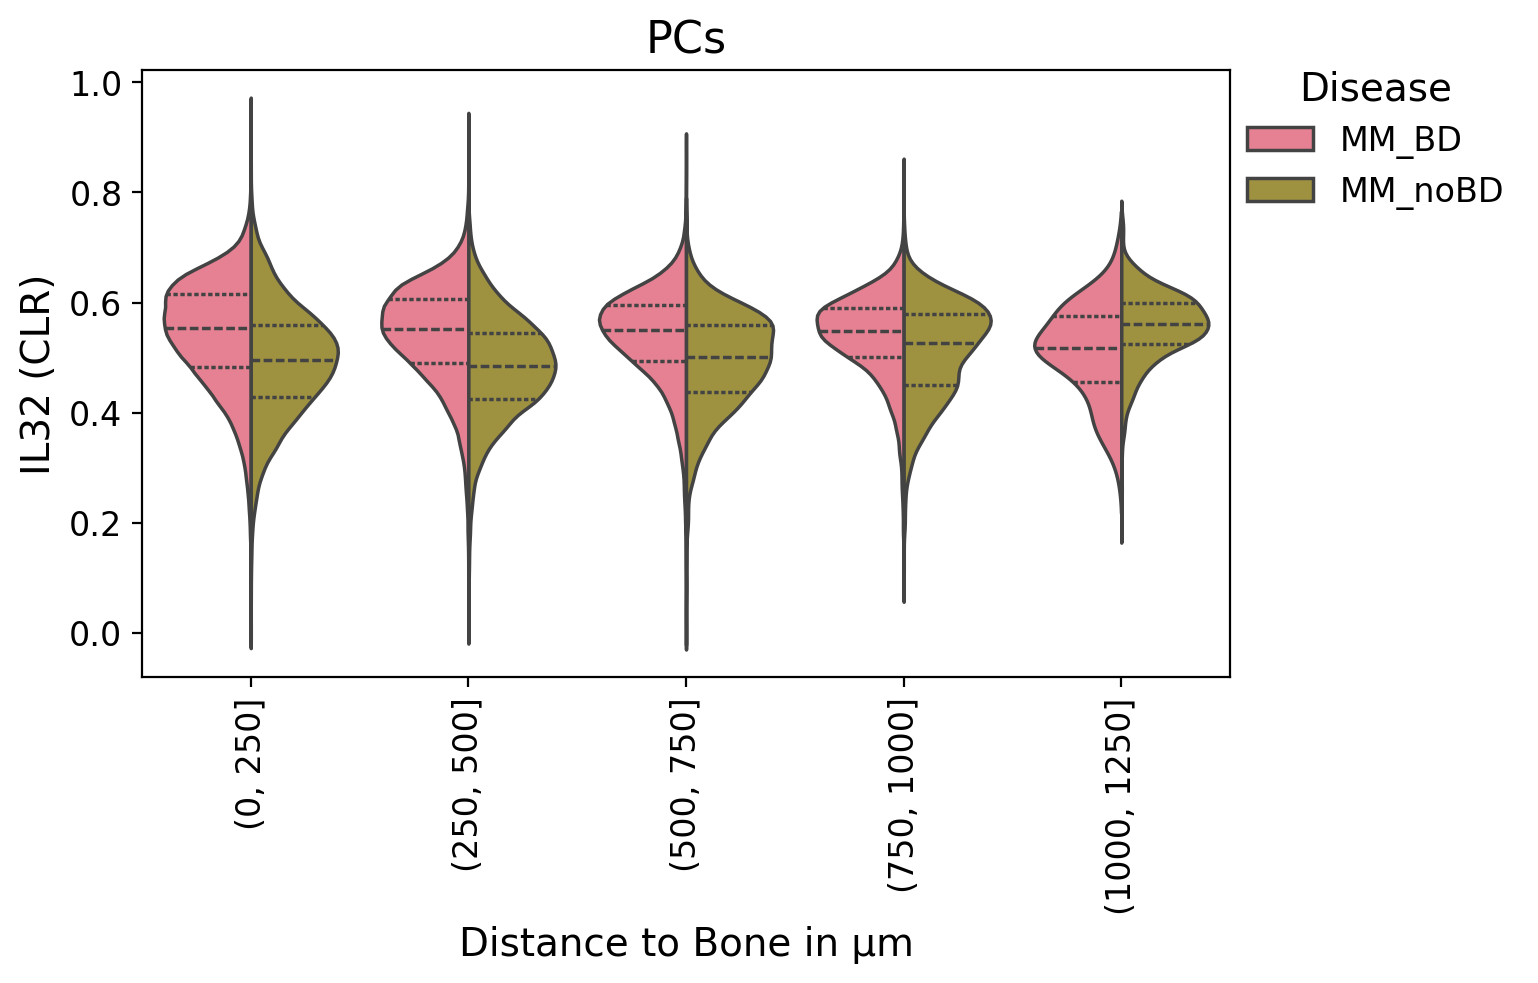

In [51]:
plt.style.use('default')
marker = 'IL32'
plt.figure(figsize=(8,5))
sns.violinplot(
    data=df,
    x="distance_bin",
    y=marker,
    hue="disease2",
    palette=disease_color_map,
    inner='quartile',
    split=True,
    scale="width",
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Distance to Bone in µm", fontsize=14)
plt.ylabel(f"{marker} (CLR)", fontsize=14)
plt.legend(title='Disease', loc='upper right', bbox_to_anchor=(1.28, 1.05), framealpha=0, fontsize=12, title_fontsize=14)
plt.title(f"{celltype}", fontsize=16)
plt.tight_layout()
if celltype == 'Plasma Cells/MM cells':
    celltype_file = 'Plasma_Cells_MM_cells'
plt.savefig(os.path.join(save_path, f"{marker}_{celltype}_distance_to_bone_violinplot.{extension}"))
plt.show()

In [52]:
df['distance_bin_center'] = df['distance_bin'].apply(lambda x: x.mid)

In [53]:
df

,CD38,Perilipin,Vimentin,B4GALT1,MPO,CathepsinK,ATP5A,RUNX2,HIF1A,CD11b,...,CD3,CPT1A,CD98,HLA-DR,ST6GAL1,CD138,distance_to_bone_corrected,disease2,distance_bin,distance_bin_center
Object 1 in TS-373_IMC77_B_001.csv,0.285836,0.294962,0.381280,0.208380,0.470309,0.000000,0.347032,0.118177,0.245371,0.422768,...,0.785446,0.734610,0.277531,0.523756,0.136619,0.104558,26.019224,MM_BD,"(0, 250]",125.0
Object 15 in TS-373_IMC77_B_001.csv,0.584050,0.226002,0.743808,0.527641,0.396565,0.118083,0.357526,0.018114,0.512743,0.553887,...,0.351875,0.695553,0.258422,0.396671,0.371555,0.546733,91.241438,MM_BD,"(0, 250]",125.0
Object 32 in TS-373_IMC77_B_001.csv,0.391237,0.254091,0.419591,0.333855,0.669573,0.089656,0.375071,0.034897,0.222456,0.423251,...,0.377810,0.568603,0.245792,0.209839,0.352995,0.122934,2.000000,MM_BD,"(0, 250]",125.0
Object 60 in TS-373_IMC77_B_001.csv,0.563274,0.243710,0.785126,0.545517,0.465828,0.098735,0.654439,0.057979,0.563328,0.603363,...,0.263463,0.769195,0.328007,0.321675,0.445502,0.397583,86.145226,MM_BD,"(0, 250]",125.0
Object 75 in TS-373_IMC77_B_001.csv,0.608792,0.340158,0.683539,0.554623,0.654572,0.102201,0.610767,0.145675,0.482252,0.577713,...,0.607238,0.694769,0.453150,0.501196,0.458932,0.391751,21.540659,MM_BD,"(0, 250]",125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Object 6578 in TS-373_IMC83_B_001.csv,0.861340,0.365933,0.825304,0.556172,0.455680,0.209952,0.649228,0.116668,0.688679,0.545271,...,0.449939,0.817067,0.613738,0.627700,0.534086,0.286428,33.241540,MM_BD,"(0, 250]",125.0
Object 6592 in TS-373_IMC83_B_001.csv,0.726540,0.307771,0.507935,0.662648,0.277004,0.182987,0.779196,0.124444,0.637949,0.575766,...,0.492101,0.785394,0.618533,0.494449,0.628639,0.270694,148.734663,MM_BD,"(0, 250]",125.0
Object 6593 in TS-373_IMC83_B_001.csv,0.588351,0.300972,0.336872,0.676870,0.228257,0.202051,0.836995,0.137087,0.516838,0.546555,...,0.521410,0.831077,0.642627,0.506378,0.636885,0.119877,156.339374,MM_BD,"(0, 250]",125.0
Object 6602 in TS-373_IMC83_B_001.csv,0.762172,0.399725,0.891862,0.605014,0.512899,0.223538,0.757393,0.127421,0.464083,0.601980,...,0.403019,0.701174,0.606858,0.582224,0.496055,0.356622,69.462220,MM_BD,"(0, 250]",125.0


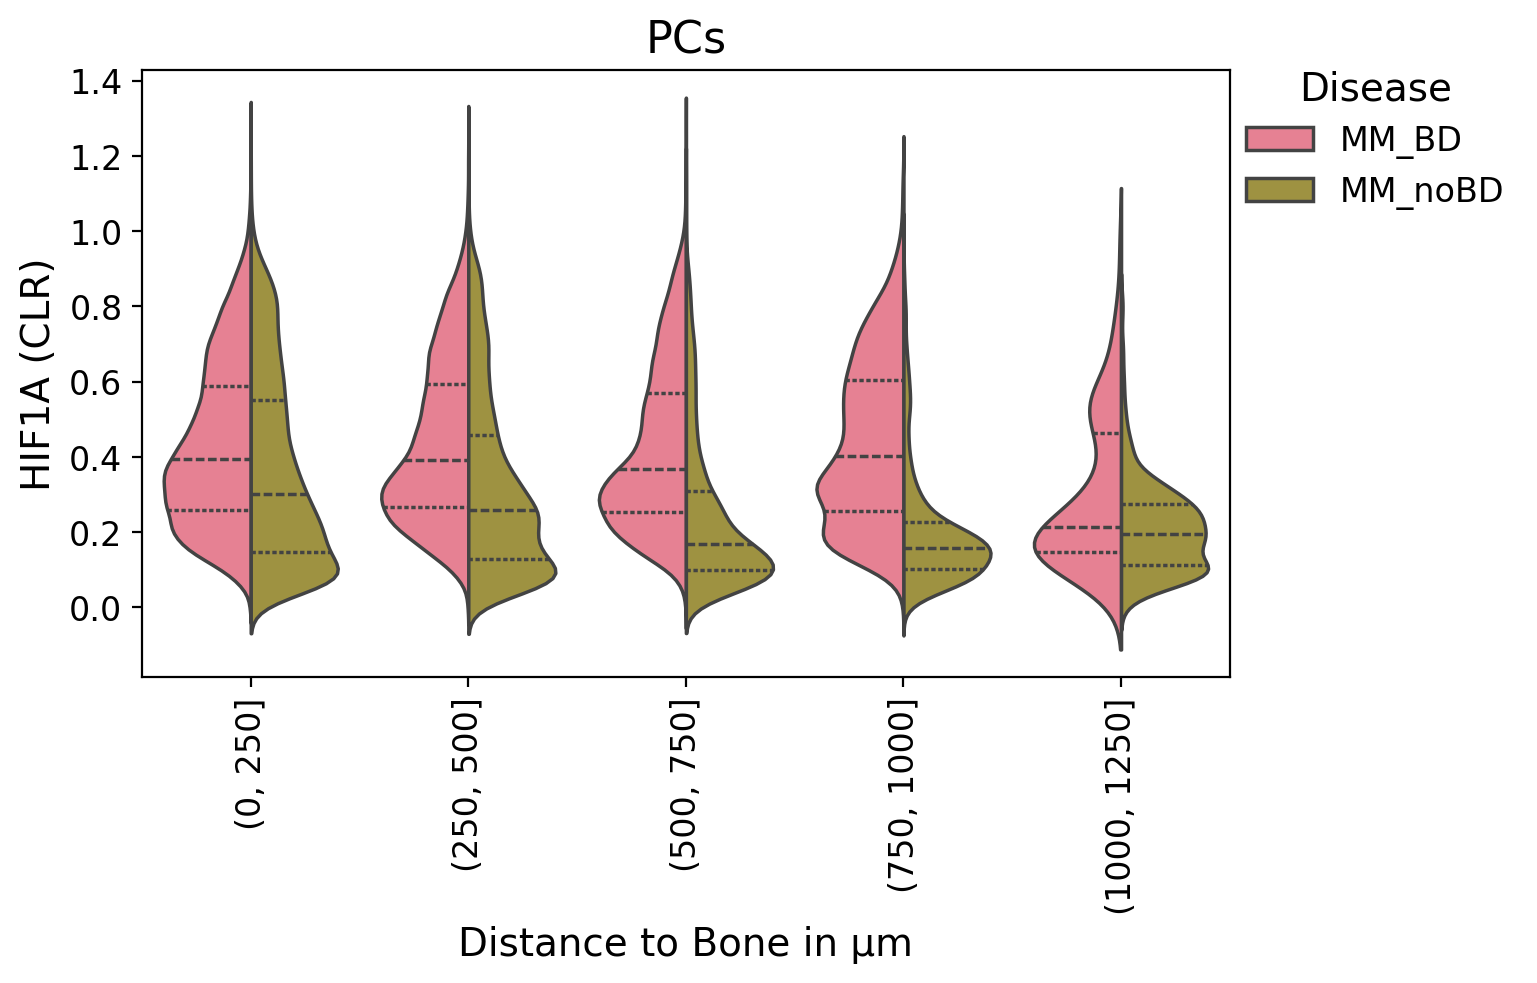

In [54]:
plt.style.use('default')
marker = 'HIF1A'
df['distance_bin'] = pd.cut(df['distance_to_bone_corrected'], 
                           bins=range(0, 1251, 250))

plt.figure(figsize=(8,5))
sns.violinplot(
    data=df,
    x="distance_bin",
    y=marker,
    hue="disease2",
    palette=disease_color_map,
    inner='quartile',
    split=True,
    scale="width",
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Distance to Bone in µm", fontsize=14)
plt.ylabel(f"{marker} (CLR)", fontsize=14)
plt.legend(title='Disease', loc='upper right', bbox_to_anchor=(1.28, 1.05), framealpha=0, fontsize=12, title_fontsize=14)
plt.title(f"{celltype}", fontsize=16)
plt.tight_layout()
if celltype == 'Plasma Cells/MM cells':
    celltype_file = 'Plasma_Cells_MM_cells'
plt.savefig(os.path.join(save_path, f"{marker}_{celltype}_distance_to_bone_violinplot.{extension}"))
plt.show()

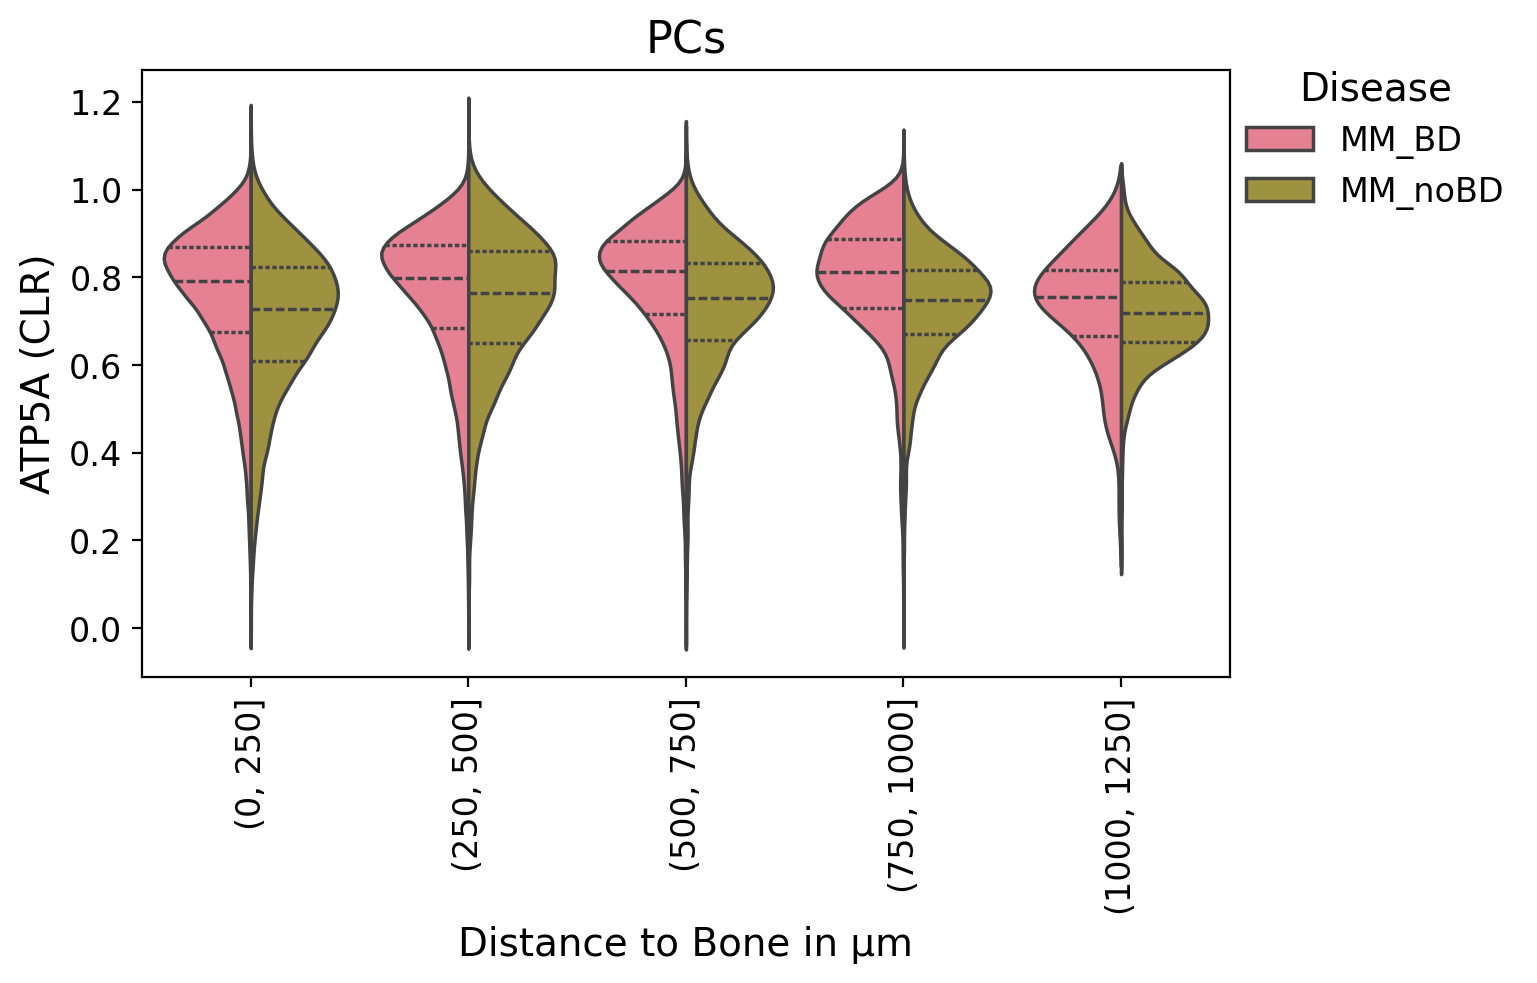

In [55]:
plt.style.use('default')
marker = 'ATP5A'
df['distance_bin'] = pd.cut(df['distance_to_bone_corrected'], 
                           bins=range(0, 1251, 250))

plt.figure(figsize=(8,5))
sns.violinplot(
    data=df,
    x="distance_bin",
    y=marker,
    hue="disease2",
    palette=disease_color_map,
    inner='quartile',
    split=True,
    scale="width",
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Distance to Bone in µm", fontsize=14)
plt.ylabel(f"{marker} (CLR)", fontsize=14)
plt.legend(title='Disease', loc='upper right', bbox_to_anchor=(1.28, 1.05), framealpha=0, fontsize=12, title_fontsize=14)
plt.title(f"{celltype}", fontsize=16)
plt.tight_layout()
if celltype == 'Plasma Cells/MM cells':
    celltype_file = 'Plasma_Cells_MM_cells'
plt.savefig(os.path.join(save_path, f"{marker}_{celltype}_distance_to_bone_violinplot.{extension}"))
plt.show()

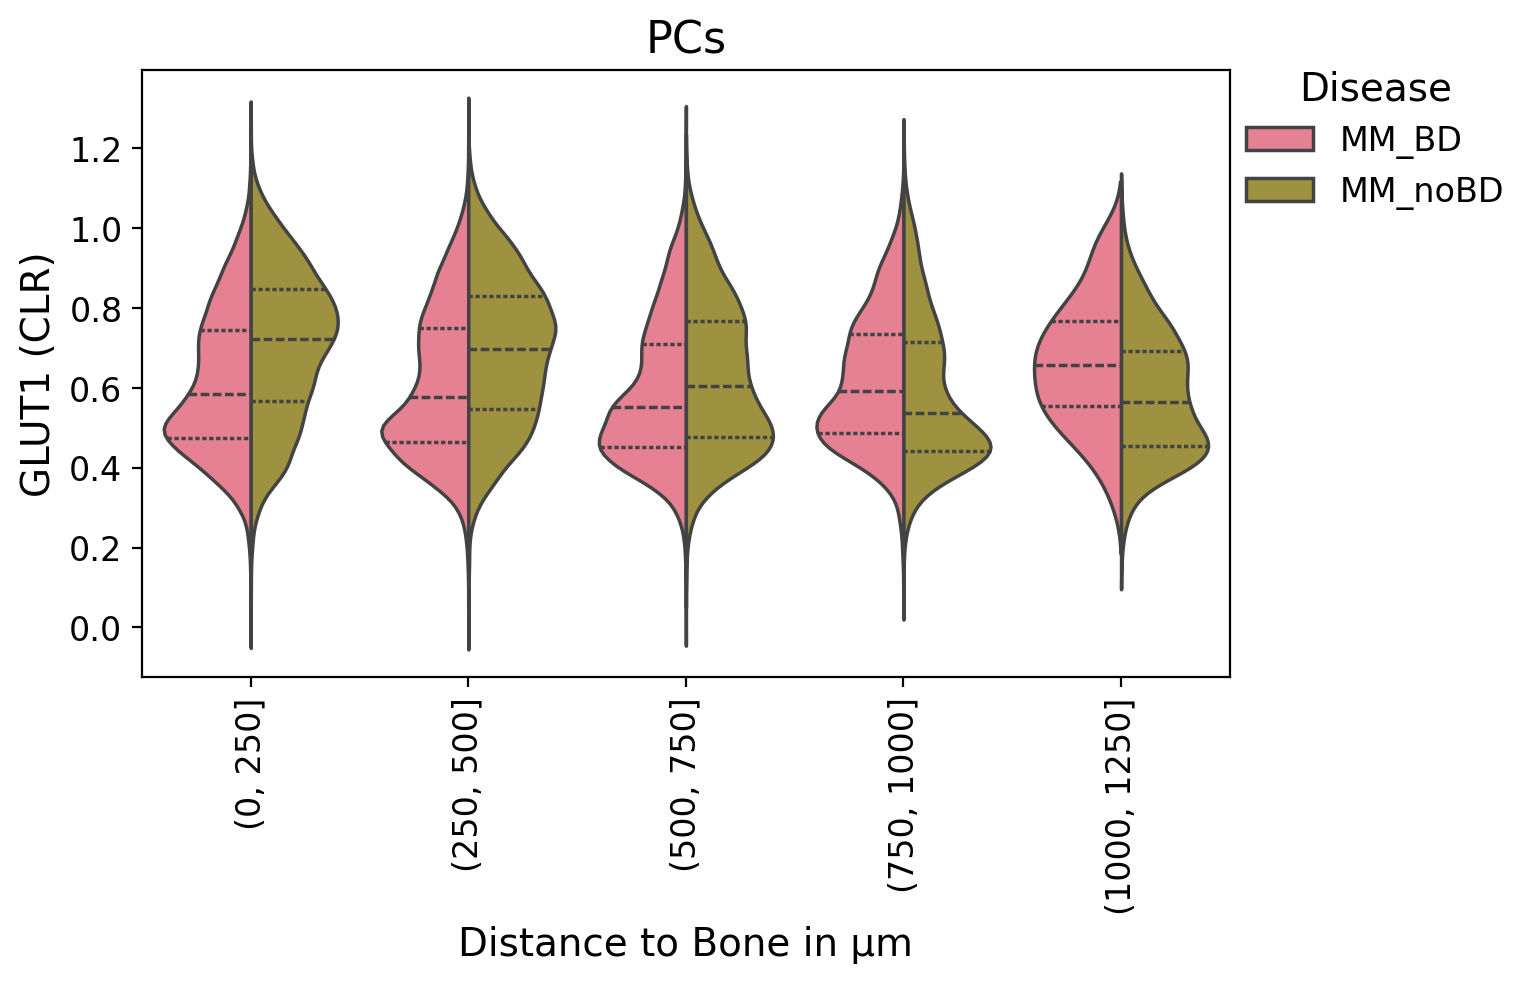

In [56]:
plt.style.use('default')
marker = 'GLUT1'
df['distance_bin'] = pd.cut(df['distance_to_bone_corrected'], 
                           bins=range(0, 1251, 250))

plt.figure(figsize=(8,5))
sns.violinplot(
    data=df,
    x="distance_bin",
    y=marker,
    hue="disease2",
    palette=disease_color_map,
    inner='quartile',
    split=True,
    scale="width",
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Distance to Bone in µm", fontsize=14)
plt.ylabel(f"{marker} (CLR)", fontsize=14)
plt.legend(title='Disease', loc='upper right', bbox_to_anchor=(1.28, 1.05), framealpha=0, fontsize=12, title_fontsize=14)
plt.title(f"{celltype}", fontsize=16)
plt.tight_layout()
if celltype == 'Plasma Cells/MM cells':
    celltype_file = 'Plasma_Cells_MM_cells'
plt.savefig(os.path.join(save_path, f"{marker}_{celltype}_distance_to_bone_violinplot.{extension}"))
plt.show()

In [57]:
def calculate_rowwise_clr_with_obs(
    adata,
    obs_marker_name: str = 'HistoneH3'
) -> pd.DataFrame:

    df = adata.to_df()
    df[obs_marker_name] = adata.obs[obs_marker_name]
    x = df.values
    log1p_x = np.log1p(x)
    mean_log1p_x_per_row = log1p_x.sum(axis=1, keepdims=True) / x.shape[1]

    geom_mean_1p_per_row = np.exp(mean_log1p_x_per_row)
    ratio = x / geom_mean_1p_per_row

    # Apply the final log1p transformation
    clr_transformed_values = np.log1p(ratio)

    # 4. Create the final DataFrame
    clr_df = pd.DataFrame(clr_transformed_values, index=df.index, columns=df.columns)

    return clr_df

In [58]:
# As Histone is in .obs, manual clr calculation is required
adata_test = adata.copy()
adata_test.X = adata_test.layers['arcsinh']
df = calculate_rowwise_clr_with_obs(adata_test, obs_marker_name='HistoneH3')
df['distance_to_bone_corrected'] = adata.obs['distance_to_bone_corrected']
df['disease2'] = adata.obs['disease2']
df['Phenotype4'] = adata.obs['Phenotype4']
celltype = 'PCs'
df = df[df['Phenotype4'] == celltype]

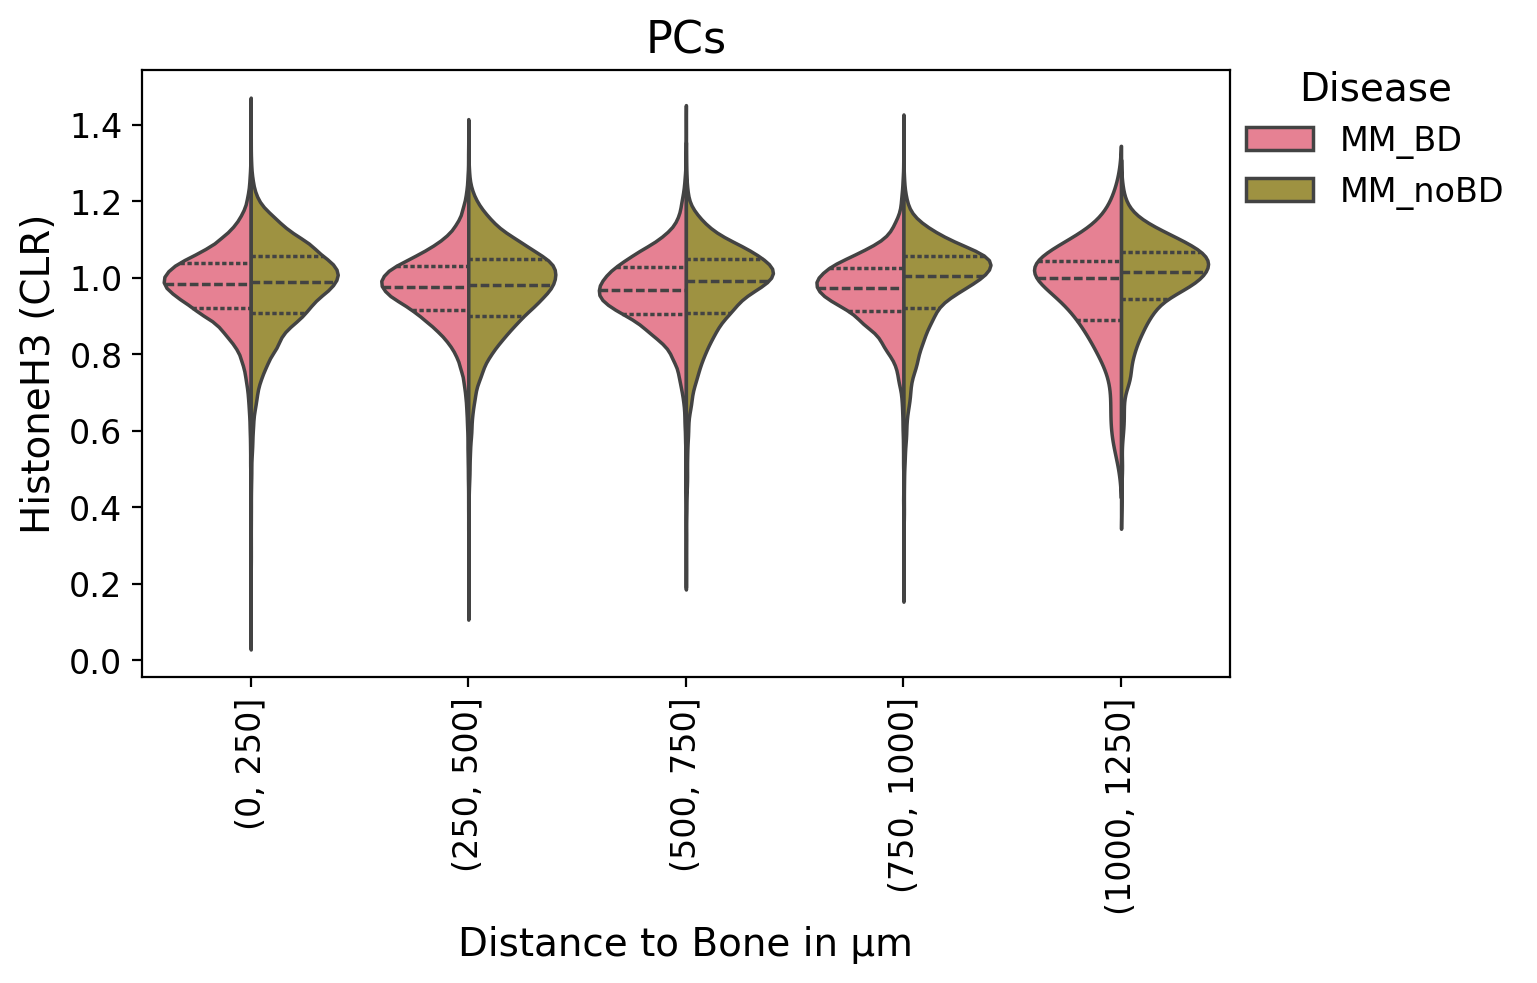

In [59]:
plt.style.use('default')
marker = 'HistoneH3'
df['distance_bin'] = pd.cut(df['distance_to_bone_corrected'], 
                           bins=range(0, 1251, 250))

plt.figure(figsize=(8,5))
sns.violinplot(
    data=df,
    x="distance_bin",
    y=marker,
    hue="disease2",
    palette=disease_color_map,
    inner='quartile',
    split=True,
    scale="width",
)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Distance to Bone in µm", fontsize=14)
plt.ylabel(f"{marker} (CLR)", fontsize=14)
plt.legend(title='Disease', loc='upper right', bbox_to_anchor=(1.28, 1.05), framealpha=0, fontsize=12, title_fontsize=14)
plt.title(f"{celltype}", fontsize=16)
plt.tight_layout()
if celltype == 'Plasma Cells/MM cells':
    celltype_file = 'Plasma_Cells_MM_cells'
plt.savefig(os.path.join(save_path, f"{marker}_{celltype}_distance_to_bone_violinplot.{extension}"))
plt.show()